# Задача 1: сравнение предложений

Дан набор предложений, скопированных с Википедии. Каждое из них имеет "кошачью тему" в одном из трех смыслов:

- кошки (животные)
- UNIX-утилита cat для вывода содержимого файлов
- версии операционной системы OS X, названные в честь семейства кошачьих

Ваша задача — найти два предложения, которые ближе всего по смыслу к расположенному в самой первой строке. В качестве меры близости по смыслу мы будем использовать косинусное расстояние.

In [1]:
import pandas as pd
import numpy as np
import re
from scipy.spatial.distance import cosine

In [2]:
# Читаем файл и разбиваем предложения на отдельные слова
words = []
sentences = []
pattern = re.compile('[a-z]+')
with open('sentences.txt') as inp:
    for line in inp.readlines():
        words += re.findall(pattern, line.strip().lower())
        sentences.append(line.strip().lower())

In [3]:
sentences[:2], words[:5]

(['in comparison to dogs, cats have not undergone major changes during the domestication process.',
  'as cat simply catenates streams of bytes, it can be also used to concatenate binary files, where it will just concatenate sequence of bytes.'],
 ['in', 'comparison', 'to', 'dogs', 'cats'])

In [4]:
print(f'Количество слов в списке: {len(words)}')
print(f'Количество уникальных слов: {len(set(words))}')

Количество слов в списке: 484
Количество уникальных слов: 254


In [5]:
# Сопоставим каждому уникальному слову свой индекс
words_dict = {}
for index, item in enumerate(set(words)):
    words_dict[item] = index
list(words_dict.items())[:5]

[('may', 0), ('interactive', 1), ('two', 2), ('editions', 3), ('common', 4)]

In [6]:
# Создадим матрицу вхождений слов в предложения
words_matrix = np.zeros([len(sentences), len(words_dict)], dtype=int)
print(f'Размерность матрицы = {words_matrix.shape}\n')

for i in range(len(sentences)):
    for key, value in words_dict.items():
        words_matrix[i, value] = len(re.findall(r'\b%s\b' % key, sentences[i]))
        
print(f'Пример предложения:\n{sentences[0]}\n')
print(f'Соответствующая ему строка матрицы:\n{words_matrix[0, :]}')

Размерность матрицы = (22, 254)

Пример предложения:
in comparison to dogs, cats have not undergone major changes during the domestication process.

Соответствующая ему строка матрицы:
[0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


In [7]:
# Найдём косинусные расстояния от первого предложения до всех остальных
cosine_distances = {}
for i in range(1, len(sentences)):
    cosine_distances[i] = cosine(words_matrix[0], words_matrix[i])

distances_df = pd.DataFrame(cosine_distances.values(),
                            index=cosine_distances.keys(),
                            columns=['cos_distance']).sort_values(by='cos_distance')

distances_df.index.name = 'sentence'
distances_df.head()

,cos_distance
sentence,
6,0.732739
4,0.777089
21,0.825036
10,0.832817
16,0.833043


In [8]:
# Два ближайших по смыслу к первому предложения
indices = distances_df.head(2).index.to_list()
print(f'Предложение:\n{sentences[0]}\n')
print(f'Первое ближайшее к нему:\n{sentences[indices[0]]}\n')
print(f'Второе ближайшее к нему:\n{sentences[indices[1]]}')

Предложение:
in comparison to dogs, cats have not undergone major changes during the domestication process.

Первое ближайшее к нему:
domestic cats are similar in size to the other members of the genus felis, typically weighing between 4 and 5 kg (8.8 and 11.0 lb).

Второе ближайшее к нему:
in one, people deliberately tamed cats in a process of artificial selection, as they were useful predators of vermin.


In [9]:
# Запись ответа в файл
with open('submission-1.txt', 'w') as out:
    out.write(' '.join(map(str, indices)))

# Задача 2: аппроксимация функции

Рассмотрим сложную математическую функцию на отрезке [1, 15]:

$f(x) = sin(\frac{x}{5}) \cdot exp(\frac{x}{10}) + 5 \cdot exp(\frac{-x}{2})$

Она может описывать, например, зависимость оценок, которые выставляют определенному сорту вина эксперты, в зависимости от возраста этого вина. По сути, задача машинного обучения состоит в том, чтобы приблизить сложную зависимость с помощью функции из определенного семейства. В этом задании мы будем приближать указанную функцию с помощью многочленов.

Как известно, многочлен степени n (то есть $w_0 + w_1 x + w_2 x^2 + \ldots + w_n x^n$) однозначно определяется любыми n + 1 различными точками, через которые он проходит. Это значит, что его коэффициенты $w_0, \ldots w_n$ можно определить из следующей системы линейных уравнений:
<br>
![title](https://d3c33hcgiwev3.cloudfront.net/imageAssetProxy.v1/SLHK79HnEeWvxwo5BbZD3w_ed4fb0020ad6ccb0b2e2ea50468b7789_lineqn.png?expiry=1599436800000&hmac=HSMBcouxjH6tKy-CyZW1AkaoNBnsfdBSzz_FNrdg_j8)


где через $x_1, \ldots, x_n, x_{n+1}$ обозначены точки, через которые проходит многочлен, а через $f(x_1), \ldots, f(x_n), f(x_{n+1}$) — значения, которые он должен принимать в этих точках.

Воспользуемся описанным свойством, и будем находить приближение функции многочленом, решая систему линейных уравнений.

In [10]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [11]:
def original_func(x):
    '''Returns observed function'''
    return np.sin(x / 5) * np.exp(x / 10) + 5 * np.exp(-x / 2)

In [12]:
def draw_funcs(func):
    '''Draws original and approximated functions'''
    ax = np.linspace(1, 15, 1000)
    plt.plot(ax, original_func(ax), 'b-', label='Original');
    plt.plot(ax, func, 'r--', label='Approximation');
    plt.title('Рассматриваемые функции')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend();

In [13]:
def build_a(xs):
    '''Builds matrix of coefficients A for equation Ax = b'''
    A = np.zeros([len(xs), len(xs)])
    for i in range(len(xs)):
        A[:, i] = xs ** i
    return A

In [14]:
def polynom_func(x, w):
    '''Builds polynomial function'''
    xs = np.array([x ** n for n in range(len(w))])
    return w.dot(xs)

In [15]:
def get_weights(xs):
    '''Returns weights w for equation wx = b'''
    b = np.array([original_func(x) for x in xs])
    A = build_a(xs)
    return linalg.solve(A, b)

In [16]:
# Настроим графики
params = {'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          'legend.fontsize': 'x-large',
          'figure.figsize': (10, 8)}
rcParams.update(params)
ax = np.linspace(1, 15, 1000)

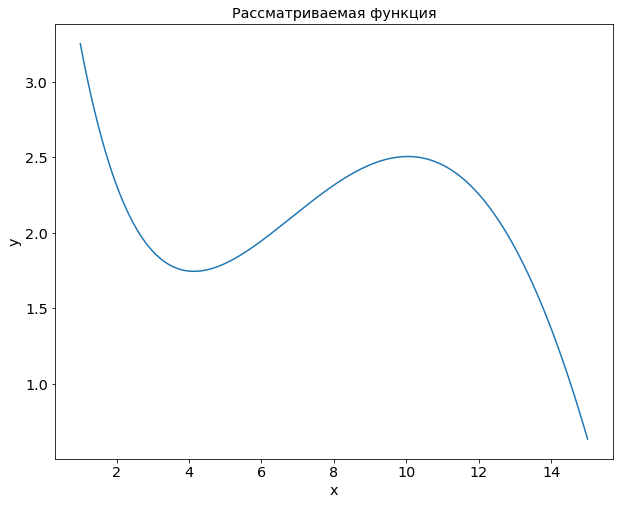

In [17]:
# График рассматриваемой функции
plt.plot(ax, original_func(ax))
plt.title('Рассматриваемая функция')
plt.xlabel('x')
plt.ylabel('y');

### 1. Многочлен 1-й степени

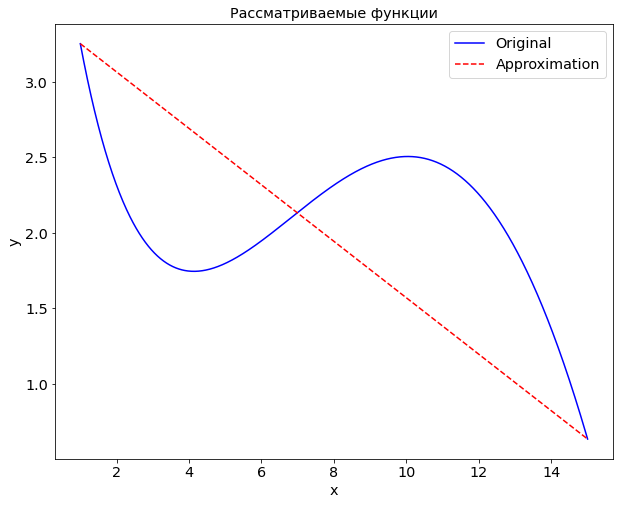

In [18]:
# Приближение многочленом 1-й степени, который совпадает
# с рассматриваемой функцией в точках 1, 15
xs = np.array([1, 15])
w = get_weights(xs)
draw_funcs(polynom_func(ax, w))

### 2. Многочлен 2-й степени

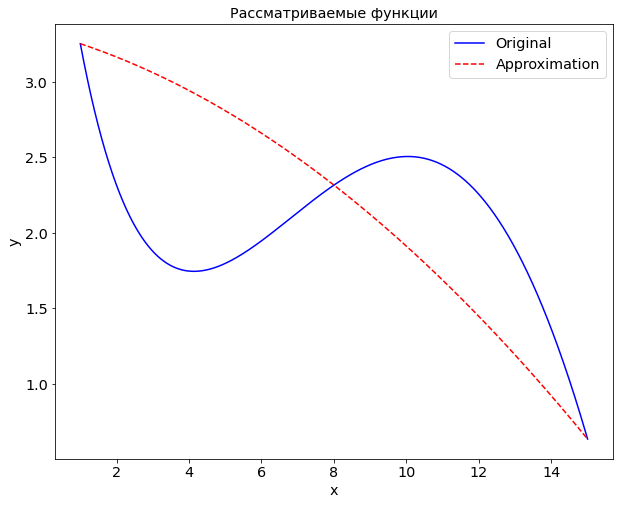

In [19]:
# Приближение многочленом 2-й степени, который совпадает
# с рассматриваемой функцией в точках 1, 8, 15
xs_2 = np.array([1, 8, 15])
w_2 = get_weights(xs_2)
draw_funcs(polynom_func(ax, w_2))

### 3. Многочлен 3-й степени

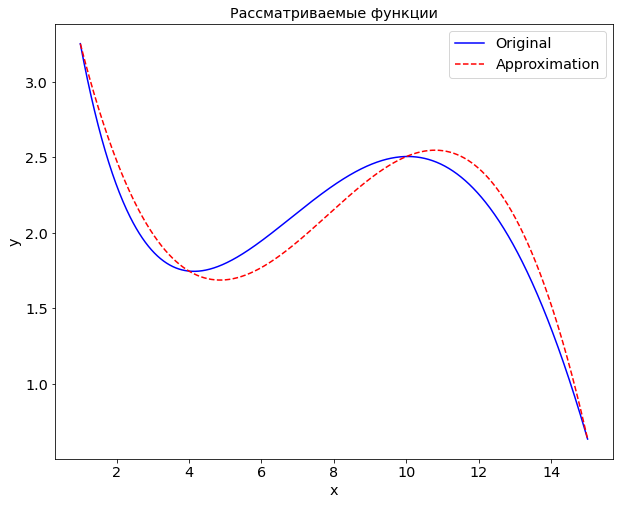

In [20]:
# Приближение многочленом 2-й степени, который совпадает
# с рассматриваемой функцией в точках 1, 4, 10, 15
xs_3 = np.array([1, 4, 10, 15])
w_3 = get_weights(xs_3)
draw_funcs(polynom_func(ax, w_3))

In [21]:
# Запись ответа в файл
with open('submission-2.txt', 'w') as out:
    out.write(' '.join(map(str, w_3)))